In [1]:
import hana_ml
from hana_ml import dataframe
from hana_ml.dataframe import create_dataframe_from_pandas
from hana_ml.algorithms.pal.partition import train_test_val_split
from hana_ml.algorithms.pal.trees import HybridGradientBoostingClassifier
from hana_ml.algorithms.pal import metrics
from hdbcli import dbapi

In [2]:
import pandas as pd
import numpy as np
#!pip install geopandas descartes
#!pip install rtree

In [3]:
host = '151ee84c-d015-4965-ad7c-5fea6d233545.hana.d022166-haas-hc-dev.dev-aws.hanacloud.ondemand.com'
port = int(443)
passwd = 'Abcd123!'
user = 'PAL'

In [4]:
conn= dataframe.ConnectionContext(address=host, port=port, user=user, password=passwd,
                               encrypt='true' ,sslValidateCertificate='false')

Structure/field names of the stations csv

|Feld             |Bedeutung                                      |
|-----------------|-----------------------------------------------|
|uuid             |UUID der Tankstelle, matcht mit den Preisen    |
|name             |Tankstellenname                                |
|brand            |Marke                                          |
|street           |Straße                                         |
|post_code        |Postleitzahl                                   |
|city             |Stadt                                          |
|latitude         |geogr. Breite                                  |
|longitude        |geogr. Länge                                   |
|first_active     |erstes Auftauchen                              |
|openingtimes_json|Öffnungszeiten als JSON

In [5]:
# load data from csv
stations_pd = pd.read_csv('/Users/d022166/Downloads/stations.csv', sep=',', header=None, skiprows=1,
                          names=["uuid","name", "brand", "street","house_number",
                                  "post_code", "city", "latitude", "longitude"])

In [6]:
stations_pd.head(5)

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude
0,00060723-0001-4444-8888-acdc00000001,BAGeno Raiffeisen eG,NaN,Künzelsauer Strasse,7,74653,Ingelfingen,49.296822,9.661385
1,005056ba-7cb6-1ed2-bceb-5332ab168d12,famila Tankstelle,FAMILA,Pascalstrasse,9,25442,Quickborn,53.742150,9.941240
2,005056ba-7cb6-1ed2-bceb-573c18314d16,star Tankstelle,STAR,Riehler Strasse,240,50735,Köln,50.961800,6.980070
3,005056ba-7cb6-1ed2-bceb-662ba1a94d1f,star Tankstelle,STAR,BAB 10 / Seeberg Ost,NaN,15345,Altlandsberg,52.550160,13.682120
4,005056ba-7cb6-1ed2-bceb-6f7b23564d23,star Tankstelle,STAR,Duisburger Straße,130,47166,Duisburg,51.489790,6.783730


In [7]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

In [8]:
# read shape-file
bw = gpd.read_file('/Users/d022166/Downloads/OD_AX_Gebiet_Kreis/AX_Gebiet_Kreis.shp')

In [9]:
bw.head(5)

,Name,Schlüssel,geometry
0,Lörrach,08336,"POLYGON ((418041.472 5303150.731, 418191.092 5..."
1,Waldshut,08337,"POLYGON ((429506.039 5301007.365, 429587.627 5..."
2,Bodenseekreis,08435,"POLYGON ((519633.579 5303228.310, 519659.499 5..."
3,Ravensburg,08436,"POLYGON ((541842.092 5316813.214, 541918.492 5..."
4,Breisgau-Hochschwarzwald,08315,"POLYGON ((395079.924 5329317.620, 395137.351 5..."


In [10]:
bw2 = bw.to_crs(epsg=4326)

In [11]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(stations_pd['longitude'], stations_pd['latitude'])]

In [12]:
stations_gdf = gpd.GeoDataFrame(stations_pd, geometry=geometry, crs=crs)

/Users/d022166/opt/anaconda3/envs/hana-ml-cloud/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [13]:
stations_gdf.head(5)

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,geometry
0,00060723-0001-4444-8888-acdc00000001,BAGeno Raiffeisen eG,NaN,Künzelsauer Strasse,7,74653,Ingelfingen,49.296822,9.661385,POINT (9.66138 49.29682)
1,005056ba-7cb6-1ed2-bceb-5332ab168d12,famila Tankstelle,FAMILA,Pascalstrasse,9,25442,Quickborn,53.742150,9.941240,POINT (9.94124 53.74215)
2,005056ba-7cb6-1ed2-bceb-573c18314d16,star Tankstelle,STAR,Riehler Strasse,240,50735,Köln,50.961800,6.980070,POINT (6.98007 50.96180)
3,005056ba-7cb6-1ed2-bceb-662ba1a94d1f,star Tankstelle,STAR,BAB 10 / Seeberg Ost,NaN,15345,Altlandsberg,52.550160,13.682120,POINT (13.68212 52.55016)
4,005056ba-7cb6-1ed2-bceb-6f7b23564d23,star Tankstelle,STAR,Duisburger Straße,130,47166,Duisburg,51.489790,6.783730,POINT (6.78373 51.48979)


In [14]:
bw3 = bw2.geometry.unary_union
within_bw = stations_gdf[stations_gdf.geometry.within(bw3)] 
print("number of stations in BW", len(within_bw))

number of stations in BW 2010


Text(0.5, 0.98, 'Service Stations in Baden-Württemberg')

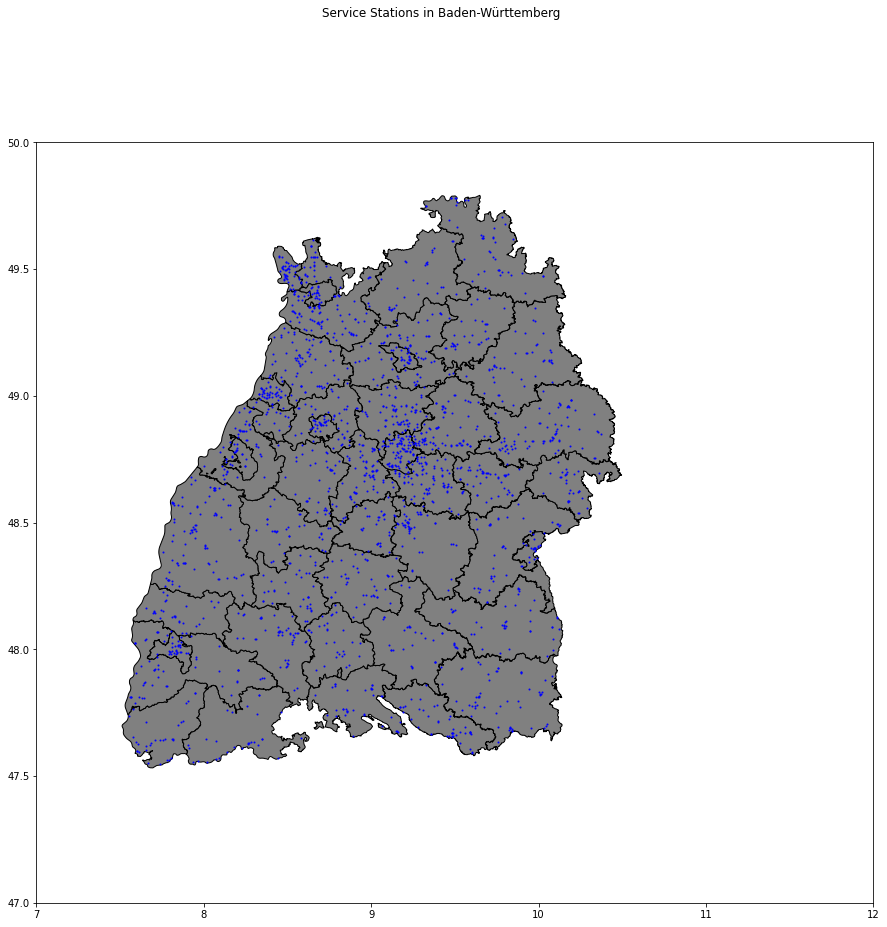

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim((7,12))
ax.set_ylim((47,50))
bw2.plot(ax=ax, facecolor='Grey', edgecolor='k')
within_bw.plot(ax=ax, marker='.', color='blue', markersize=4)
fig.suptitle('Service Stations in Baden-Württemberg')

#### narrow down to Rhein-Neckar-Kreis

In [21]:
rnk =  bw2[bw2['Name'] =='Rhein-Neckar-Kreis']
rnk = rnk.geometry.unary_union
within_rnk = stations_gdf[stations_gdf.geometry.within(rnk)] 
print("number of stations in Rhein-Neckar-Kreise", len(within_rnk))

number of stations in Rhein-Neckar-Kreise 111


### HANA
hana table create column table FUEL_PRICES_RNK ("date" timestamp,"station_uuid" nvarchar(50),"diesel" decimal(6,4),"e5" decimal(6,4),"e10" decimal(6,4),"dieselchange" int ,"e5change" int ,"e10change" int );

In [ ]:
connection = dbapi.connect(address=host, port=port, user=user, password=passwd,
                                   encrypt='true' ,sslValidateCertificate='false'
                            )

In [ ]:
connection.isconnected()

In [ ]:
cursor = connection.cursor()

In [ ]:
cursor.execute('create column table FUEL_PRICES_RNK ("date" timestamp,"station_uuid" nvarchar(50),"diesel" decimal(6,4),"e5" decimal(6,4),"e10" decimal(6,4),"dieselchange" int ,"e5change" int ,"e10change" int );')

### Massive Mode Support Enhancement

- supported in ARIMA, Auto ARIMA, Additive Model Forecast, UnifiedClassification, UnifiedRegression

### Time series forecasting using Prophet (Additive Model Forecast)

In [28]:
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast

In [22]:
df_train = conn.sql('select * from "PAL"."FUEL_PRICES_RNK" where "date" < \'2022-06-14 00:00:00.000\'')

In [23]:
df_test_groundtruth = conn.sql('select * from "PAL"."FUEL_PRICES_RNK" where "date" >= \'2022-06-14 00:00:00.000\'')

In [24]:
df_test = conn.sql('select * from "PAL"."FUEL_PRICES_RNK_TEST"')

In [25]:
df_train = df_train.drop(["diesel", "e10", "dieselchange", "e5change", "e10change"])
df_test = df_test.drop(["diesel", "e10", "dieselchange", "e5change", "e10change"])

In [26]:
df_test.head(5).collect()

,date,station_uuid,e5
0,2022-06-19 23:02:08,e1a15081-2589-9107-e040-0b0a3dfe563c,0
1,2022-06-14 07:52:09,c080d550-c6ce-46d2-bc99-af48136c3ada,0
2,2022-06-14 07:54:08,06e5e50a-3cd9-4420-ae63-c76ff3ed9a5c,0
3,2022-06-14 07:55:07,44235fed-c890-4450-8443-df853efc808a,0
4,2022-06-14 08:04:09,542f5d00-8790-4f52-a1cb-8780ad9da906,0


In [29]:
amf = AdditiveModelForecast(massive=True,growth='linear',
                                changepoint_prior_scale=0.06,
                                )

In [30]:
amf.fit(data=df_train, key="date", group_key="station_uuid")

In [31]:
amf.model_.head(5).collect()

,GROUP_ID,ROW_INDEX,MODEL_CONTENT
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."
1,0e5f8257-c5e6-44f2-8d7f-4ba90f7b9646,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."
2,10d13975-7819-4c49-86be-3465bfdc59f9,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."
3,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."
4,11751341-2a8d-4408-af81-a4a01e054314,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."


In [32]:
result = amf.predict(data=df_test, key="date", group_key="station_uuid")

In [33]:
result[0].head(10).collect()

,GROUP_ID,date,YHAT,YHAT_LOWER,YHAT_UPPER
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 05:04:12,2.012313,1.958690,2.071985
1,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 05:14:10,2.030919,1.972780,2.085280
2,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 07:52:09,1.974304,1.919735,2.025204
3,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 08:12:09,1.955824,1.901473,2.011890
4,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 09:16:09,1.923315,1.865479,1.978909
5,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 10:32:09,1.921277,1.864437,1.979853
6,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 10:52:08,1.921716,1.864430,1.977378
7,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 12:16:09,1.914839,1.856314,1.972315
8,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 13:32:09,1.909596,1.851363,1.966009
9,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 13:52:10,1.910571,1.857107,1.963721


In [38]:
result_pd = result[0].collect()

### plot fuel prices for one service station

In [34]:
stations_pd[stations_pd['uuid']=="018e8f3e-ae2f-40bc-89c1-bc3fe20eb462"]

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,geometry
1032,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,Aral Tankstelle,ARAL,Hauptstraße,166,69242,Mühlhausen,49.24805,8.735546,POINT (8.73555 49.24805)


In [35]:
# not using hana -> todo
to_plot_pd = df_train.filter('"station_uuid" =\'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\'').collect()

In [36]:
to_plot_gt_pd = df_test_groundtruth.filter('"station_uuid" =\'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\'').sort('date').collect()

In [39]:
to_plot_pred_pd = result_pd[result_pd['GROUP_ID']=="018e8f3e-ae2f-40bc-89c1-bc3fe20eb462"]

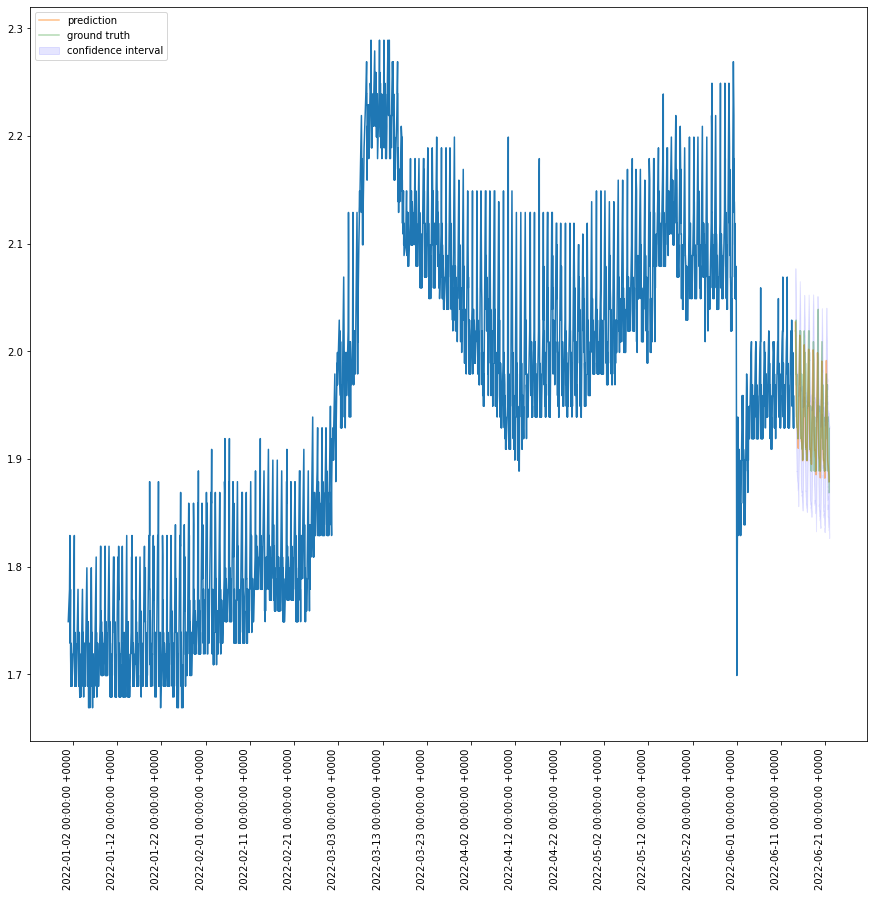

In [47]:
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
figure(figsize=(15, 15))

n = 1000 # number of points to plot
to_plot_pd = to_plot_pd.sort_values('date', ascending=True)
to_plot_pd['date'] = pd.to_datetime(to_plot_pd['date'],  utc=True)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S %z'))  #'%Y-%m-%d %H:%M:%S.%f %z %Z'
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.gcf().autofmt_xdate(rotation=90)


plt.plot(to_plot_pd['date'], to_plot_pd['e5'] )
plt.plot(to_plot_pred_pd['date'], to_plot_pred_pd['YHAT'], label='prediction', alpha=.5 )
plt.plot(to_plot_gt_pd['date'], to_plot_gt_pd['e5'], c='green', alpha=0.3, label='ground truth' )
plt.fill_between(to_plot_pred_pd['date'], to_plot_pred_pd['YHAT_LOWER'], to_plot_pred_pd['YHAT_UPPER'], color='b', alpha=.1, label= 'confidence interval')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#create column table "PAL"."FUEL_PRICES_RNK_TEST" as
#(select * from "PAL"."FUEL_PRICES_RNK" where "date" >=  '2022-06-14 00:00:00.000');
#select * from  "PAL"."FUEL_PRICES_RNK_TEST";

#UPDATE "PAL"."FUEL_PRICES_RNK_TEST" SET "e5" = 0.0;